# Energy spectrum of emitted electrons from ionization events

Directly calls rsoopic.h2crosssections.ejectedEnergy and rsoopic.h2crosssections.generateAngle to check that the energy spectrum and angular distribution, respectively, of emitted electrons look OK. Unit tests will later be developed based on the code snippets below.

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_e
#import rsoopic.h2crosssections as h2crosssections
# Since PYTHONPATH is ignored, modify sys.path directly...
sys.path.insert(1, '/home/vagrant/jupyter/rsoopic/rsoopic')
import h2crosssections
import random

# Warp
# Origin date: Mon, 2 Jul 2018 16:00:48 -0600
# Local date: Mon, 2 Jul 2018 16:00:48 -0600
# Commit hash: b464829
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warp.pyc
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warpC.so
# Thu Sep 13 23:04:20 2018
# import warp time 0.562320947647 seconds
# For more help, type warphelp()


1000.0147600315081
Spent 0.003 s generating ejected energies
max. particle energy:  482.9443455964465  eV


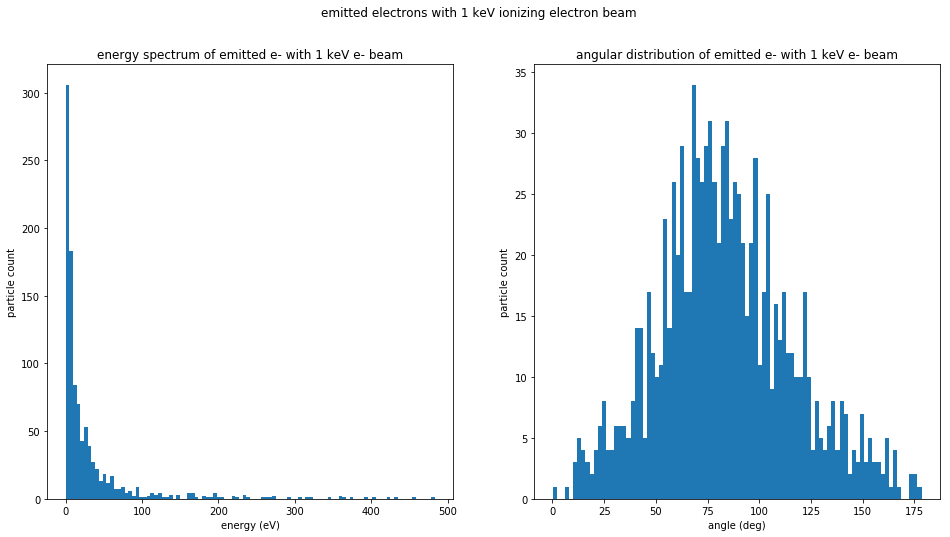

In [7]:
gamma = lambda v: math.sqrt(1./(1.-v*v/(c*c)))
#for i in range(10):
#    beta = 0.0624 + i * 1.e-5
#    v = beta * c
#    print i, beta, m_e * c * c * (gamma(v) - 1.) / e

beta = 0.06247 # for 1keV kinetic energy
n = 1000
v = np.full((n), beta * c)

energy = h2crosssections.ejectedEnergy(v, n)
print 'max. particle energy: ', energy.max(), ' eV'

eps = m_e * c * c * (gamma(beta * c) - 1.) / e # incident energy in eV
angle = h2crosssections.generateAngle(n, energy, np.full((n), eps))
angle *= 180. / math.pi

Xsect_fig_1, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 1 keV ionizing electron beam (rsoopic cross section)')

ax1.hist(energy, 100)
ax1.set_title('energy spectrum of emitted e- with 1 keV e- beam')
ax1.set_xlabel('energy (eV)')
ax1.set_ylabel('particle count')
ax2.hist(angle, 90)
ax2.set_title('angular distribution of emitted e- with 1 keV e- beam')
ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('particle count')
ax2.grid(True)
plt.savefig('Xsect_analysis1.png')
plt.show()

## Moller cross section

Implementation of pure Moller cross section for comparison

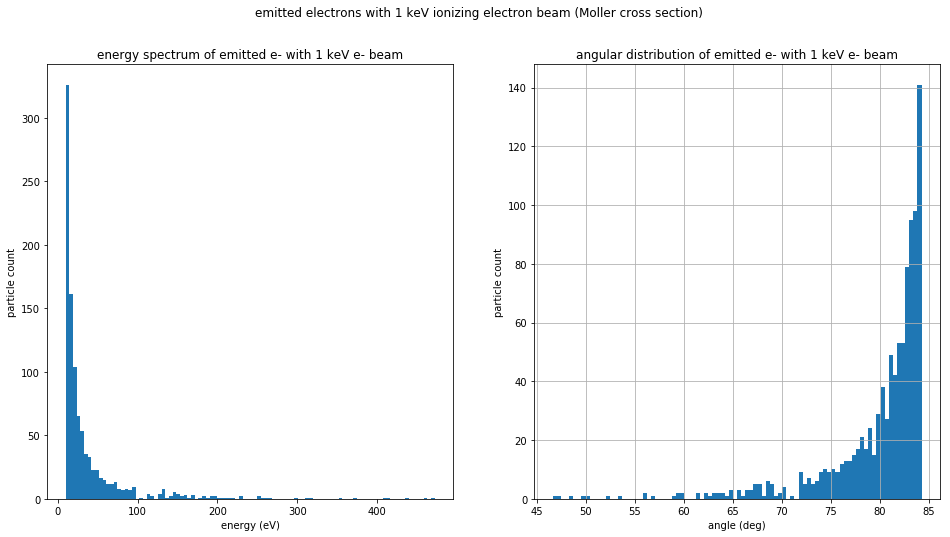

In [8]:
eps_min = 10. # value picked to give good agreement with rsoopic cross section results above
Ce = 2.0 * m_e * c * c / e

for i in range(n):
    Xrand = random.random()
    energy[i] = eps * eps_min / (eps - Xrand * (eps - 2 * eps_min))
    costheta = energy[i] * (eps + Ce)
    costheta /= eps * (energy[i] + Ce)
    costheta = math.sqrt(costheta)
    angle[i] = 180. / math.pi * math.acos(costheta)

Xsect_fig_2, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 1 keV ionizing electron beam (Moller cross section)')

ax1.hist(energy, 100)
ax1.set_title('energy spectrum of emitted e- with 1 keV e- beam')
ax1.set_xlabel('energy (eV)')
ax1.set_ylabel('particle count')
ax2.hist(angle, 90)
ax2.set_title('angular distribution of emitted e- with 1 keV e- beam')
ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('particle count')
ax2.grid(True)
plt.savefig('Xsect_analysis2.png')
plt.show()

The emitted-electron energy spectrum with the existing rsoopic cross section is in reasonable agreement with Moller at 1keV incident energy, but the angular distribution is much broader.